<a href="https://colab.research.google.com/github/edwardtjoe/ASL-Recognition/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [39]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cv2
import h5py

from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, load_model, save_model
from keras.layers import (Dense, Dropout, GRU, Flatten, Conv2D, MaxPooling2D,
                          AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D)
from keras.optimizers import adam_v2
from keras import utils, layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import Model

import shutil
from keras.preprocessing.image import (load_img, 
                                       img_to_array,
                                       ImageDataGenerator)
from keras.applications.vgg16 import VGG16

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

from keras.applications.resnet import ResNet50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 0: Overview



## 0.1. Motivation/Objective

American Sign Language (ASL) is one of the most commonly used sign languages in the world. By some estimates, ASL is used by about [250,000 to 500,000](https://www.gallaudet.edu/documents/Research-Support-and-International-Affairs/ASL_Users.pdf) people in North America alone. Various statistics show that those with hearing disabilities are highly disadvantaged as compared to their peers.

|Category|Grouping|Normal|Disabled|Difference|
|--------|--------|------|--------|----------|
|Education|High School Dropout Rate|18.7%|44.4%|2.37x|
||College Graduation Rate|12.8%|5.8%|0.45x|
||Post College Graduation Rate|9.2%|4.8%|0.52x|
|Employment|16+ yo|91.2%|83.9%|0.92x|
||16 - 44 yo|82%|58%|0.71x|
||45 - 64 yo|73%|46%|0.63x|
|Income|$10K - $25K|26%|28%|1.08x|
||$50K+|29%|14%|0.48x|

With these statistics in mind, we should ask ourselves: beyond their physical disability, how much **more** should it cost to be disabled?

That begs the question: how can we facilitate the inclusion of deaf people into society?

With the rise in remote work and increased use of video conferencing tools such as Google Meet, Zoom and Microsoft Teams, one way we can help facilitate their participation is by embedding a sign language interpreter for the deaf to speak to their non-deaf peers. YouTube currently has a tool to create text captions based on sound and language recognition. Building upon that idea, this project aims to create a tool to recognize ASL sign languages to be interpreted by text captioning.

However, understanding my current limits, my current goal is to train and recognize static alphabetical gestures in ASL.

## 0.2. Datasets

|No.|Folder name|Description|
|---|-----------|-----------|
|1.|Gestures|Dataset of 26 gestures split into training and testing set for model training|
|2.|Model|Various models trained with different hyperparameters|
|3.|Results|Dataset of results after model is tested onto the testing set (CSV)|
|4.|History|Model metrics (accuracy, loss, val_accuracy, val_loss)|
|5.|CreateGestures.py|Python file to create dataset.|

## 0.3. Project Flow

Steps:
1. Prepare dataset created using ```CreateGestures.py```.
2. Train model
3. Test model
4. Observations/Misclassification Analysis
5. Conclusions and recommendations.

Model creation and evaluation will be split into two main parts. In the first part, I train a model for 5 gestures using VGG16. Then I test the model, evaluate the results and note some observations.

In the second part, I conduct the same processes as the first part, but the model will be trained on all 26 alphabets and gestures.

# Part 1: Prepare Dataset

This was the dataset created from CreateGestures.py. It contains a total of 52,000 images consisting of 2,000 images per gesture (per alphabet).


## 1.1. Set training and testing folder path

I set the training and testing path for the folders to be used later on for training and testing the model using ImageDataGenerator. For consistency, I am also setting the image dimensions to 224, 224 for model fitting in Part 2.

In [40]:
train_path = '/content/drive/MyDrive/Colab/ASL/gestures/train'
test_path = '/content/drive/MyDrive/Colab/ASL/gestures/test'
image_x, image_y = 224, 224

## 1.2. Split Train and Test

A few things are going on here. First, we create a function to create folders if the folder does not exist. This function will be used to split the testing set from the training set for a blind test of the model that will be made.


In [ ]:
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

I randomly chose 20% of the original training images to be placed onto the testing set. To fix the images moved onto the testing set, I set a ranodm seed and selected 400 random numbers which relates to the image number, i.e. if '1' is selected, then image '1.jpg' will be moved from the training set into the testing set.

In [41]:
np.random.seed(42)
jpg_list = np.random.choice([i for i in range(1, 2001)], 400, replace=False)

The cell below moves the image numbers selected from jpg_list onto the testing set. A total of 10,400 images were moved into the training set, consisting of 400 images per alphabet gesture.

In [ ]:
alphabet_numeric = range(1, 27)                   # A-Z: 1-26

for number in alphabet_numeric:
    for jpg_num in jpg_list:
        file_path = '/content/drive/MyDrive/Colab/ASL/gestures/train/' + str(number) + '/' + str(jpg_num) + '.jpg'
        dest_path = '/content/drive/MyDrive/Colab/ASL/gestures/test/' + str(number) + '/'
        if os.path.exists(dest_path):
            shutil.move(file_path, dest_path)
            print(f'path exist, alphabet number: {number}')
        else:
            create_folder(dest_path)
            print(f'no path, alphabet number: {number}')
            if os.path.exists(dest_path):
                print(f'path created, alphabet number: {number}')
                shutil.move(file_path, dest_path)
            else:
                print(f'path not created, alphabet number: {number}')
            

## 1.3. Split Train and Valid

ImageDataGenerator splits the remaining images from the train folder onto a 'train' and a 'validation' set. The validation set will be used to test the model created by using the training set. I selected 25% of the remaining training set to be a validation set, but this number can be adjusted according to the user's preference.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.25
                                   )

train_gen = train_datagen.flow_from_directory(
    directory=train_path,                            # Training directory
    target_size=(image_x, image_y),                  # Resize to (224, 224) for vgg16 model
    seed=42,
    subset='training',
    class_mode='categorical',                        # 26 categories: A-Z
    color_mode='rgb',                                # Convert back from grayscale to RGB
    shuffle=True
)

validation_gen = train_datagen.flow_from_directory(
    directory=train_path,                            # Training directory
    target_size=(image_x, image_y),                  # Resize to (224, 224) for vgg16 model
    seed=42,
    subset='validation',
    class_mode='categorical',                        # 26 categories: A-Z
    color_mode='rgb',                                # Convert back from grayscale to RGB
    shuffle=True
)


Found 31200 images belonging to 26 classes.
Found 10400 images belonging to 26 classes.


# Part 2. Presets and Functions

## 2.1. Presets
Before training the model, I am setting several presets to be used in training the model.

Initially, I had used ```batch_size = 32```, which continuously resulted in a val_accuracy of 3.84% (aka 1 in 26) when training the model on all alphabets. This is equal to just choosing a random alphabet out of the 26 that we have, which provided absolutely no predictive value. This happens because if each batch has just 32 observations while there are 26 classes, each class would be represented in the batch just once on average. Due to the lack of representation of each class in the batch, the model did not train well. As such, I used ```batch_size = 256``` to allow for about 10 gestures per class to be present in every batch.

As for ```steps_per_epoch```, I had considered using the whole training set, but it would have taken too much time to train the model. Hence, I used the total number of observations divided by the batch size to train the model.

Meanwhile, since the validation set had just 25% of the total training set, ```validation_steps``` was set to default. This allowed the validation set to be trained much better.

In [ ]:
total_train = len(train_gen.filenames)
total_valid = len(validation_gen.filenames)
batch_size = 256

## 2.2. Model Training Function

These functions were made to help me re-run models much faster. Rather than creating new models (and writing the codes again), using this function saved me a lot more time to optimize the models.

In [ ]:
def model_instantiate(model_preset, add_layers, version, dropout_rate=0, gestures=26, epochs=50):
    '''
    Instantiate VGG16 model with added layers and dropout rate.

    model: Either VGG16 or ResNet50
    add_layers: List of layer input sizes to add in ascending order. i.e. [32, 64....]
    dropout_rate: dropout rate to be used. Default=0
    gesures: number classes in output
    version: version number to save model and checkpoints
    epochs: number of epochs to test
    '''

    # Setting file name for model checkpoint and to save model
    filename = f'/content/drive/MyDrive/Colab/ASL/models/{model_preset}_{version}.h5'

    # Instantiating sequential model
    model = Sequential()

    # There are only two model presets, VGG16 or ResNet50, so I used if-else.
    if model_preset == 'VGG16':
        model.add(VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(image_x, image_y, 3)))
    else:
        model.add(ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(image_x, image_y, 3)))
        
    # Freezing pretrained models
    for layer in model.layers:
        layer.trainable = False

    # Pooling model
    model.add(GlobalMaxPooling2D())

    # Adding layers to preset model
    for each_layer in add_layers[::-1]:
        model.add(Dense(each_layer, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Setting model output size
    model.add(Dense(gestures, activation='softmax'))
    model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    summary = model.summary()
    history = model.fit(
        train_gen,
        steps_per_epoch=(total_train//batch_size),
        epochs = epochs,
        validation_data=validation_gen,
        callbacks=callbacks_list(filename),
        batch_size = batch_size,
        verbose = 1)
    
    # Saving model
    model.save(filename, save_format='h5')
    return history, model, summary

## 2.3. Checkpoints Function

Three callback functions were used: ```EarlyStopping```, ```ReduceLROnPlateau``` and ```ModelCheckpoint```.
1. Early stopping causes the model to stop when the ```patience``` condition was met. I set ```patience = 7```, which means that if the model did not improve after 7 epochs, the model will stop learning.
2. ReduceLROnPlateau reduces the learning rate when there is no improvement when the ```patience``` condition was met. I set ```patience = 3```  and ```factor = 0.6```, which means that the model will reduce its learning rate to 0.6x when the model does not improve after 3 epochs. I had set the ```patience - 7``` to allow learning rate to reduce twice and then train on one more epoch before stopping. Visually, it's as such:
> Early stopping patience (7) = 2 x Learning rate reduction (2 x 3) + 1 more epoch (1)
3. ModelCheckpoint is used to set our optimization criteria. Since my aim is to best predict an input image, I set ```monitor = val_accuracy```.

In [ ]:
def callbacks_list(filename):
    '''
    List of callbacks used for model
    version_number: Model version number. Used to save the checkpoints to be used in callbacks. 
    '''
    early = EarlyStopping(
        monitor='val_accuracy', 
        patience=7,
        verbose=1,
        restore_best_weights=True,
        mode='max')
    lr_reduce = ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.6, 
        patience=3, 
        verbose=1, 
        mode='max', 
        min_lr=5e-5)
    model_checkpoint = ModelCheckpoint(
        filepath=filename,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',                             # We want to find maximum val_acc
        verbose=1)
    return early, lr_reduce, model_checkpoint

## 2.4. Save History Metrics

In [ ]:
def history_dataframe(history, version):
    '''
    Create dataframe of history metrics
    History: Chosen history after model fitting
    Version: File version number
    '''
    acc = pd.DataFrame(history.history['accuracy'], columns=['accuracy'])
    val_acc = pd.DataFrame(history.history['val_accuracy'], columns=['val_accuracy'])
    loss = pd.DataFrame(history.history['loss'], columns=['loss'])
    val_loss = pd.DataFrame(history.history['val_loss'], columns=['val_loss'])
    merged = pd.concat(objs=(acc, val_acc, loss, val_loss), axis=1)
    merged['version'] = version
    merged.reset_index(inplace=True)
    merged['index'] = merged['index'].map(lambda x: int(x)+1)
    merged = merged.rename(columns={'index': 'epoch'})
    merged.to_csv(f'/content/drive/MyDrive/Colab/ASL/history/history_v{version}.csv', index=False)
    return merged

## 2.5. Metrics Plot Function

In [ ]:
def plot_metric(history, metric):
    '''
    Plots metrics of chosen history
    History: Chosen history after model fitting
    Metric: Either 'accuracy' or 'loss'
    '''

    metric_score = history.history[metric]
    val_metric_score = history.history[f'val_{metric}']
    epochs = range(1, len(history.history[metric]) + 1)
    plt.plot(epochs, metric_score, 'g', label=f'Training {metric}')
    plt.plot(epochs, val_metric_score, 'b', label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    return plt.show()

# Part 3: Train Models

## 3.1. VGG16


### 3.1.1. Optimized Model

I used a range of numbers to optimize the function, including increasing and adjusting these hyperparameters:

1. Freezing/Unfreezing pre-trained model
2. Adding/Decreasing layers
3. Dropout rate


In [ ]:
add_4 = [64, 128, 256, 512]
history, model, summary = model_instantiate(
    model_preset = 'VGG16',
    add_layers = add_4,
    dropout_rate=0.25,
    version=1234,
    gestures=26,
    epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 26)                1690      
                                                                 
Total params: 14,749,210
Trainable params: 34,522
Non-trainable params: 14,714,688
_____________________________________

For the optimized model, the number of trainable parameters were 436,826, which represented 4 added layers of 64, 128, 256 and 512.

Looking at the history in a dataframe, we get:

### 3.1.2.Save History

In [ ]:
history_dataframe(history, 'VGG16')

,epoch,accuracy,val_accuracy,loss,val_loss,version
0,1,0.139463,0.474712,3.003901,2.478834,trial
1,2,0.383781,0.703173,2.174834,1.663108,trial
2,3,0.531508,0.821250,1.652374,1.186769,trial
3,4,0.623709,0.863558,1.312279,0.904126,trial
4,5,0.675103,0.901442,1.121134,0.709312,trial


### 3.1.3. Plot Metrics

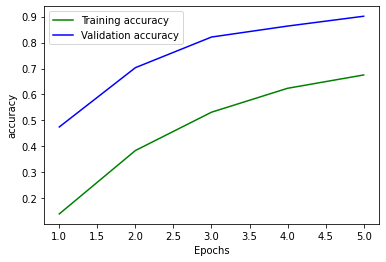

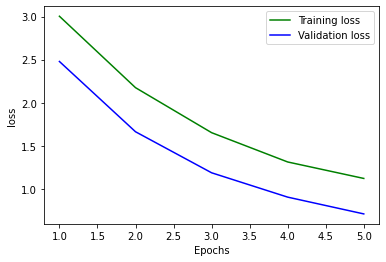

In [ ]:
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

Plotting ```accuracy``` and ```loss```, there seemed to be a large divergence between training metric and validation metric in the initial epochs, which concurrently decreased at higher epoch numbers.

**Observations**
1. I found was that unfreezing the VGG16 model did not affect much of the accuracy in the later epochs, so I decided to freeze them
2. There was a need to balance the number of added layers and dropout rates to adjust for underfitting and overfitting.
3. A higher number of layers needed to be added to increase bias and predictive power.
4. However, with the increase in bias, there was a need to adjust the dropout rate accordingly.
5. When dropout rates were too high or too low, the model was either too underfit or overfit. I found that the optimized model used a constant dropout of 0.25.

## 3.2. ResNet50


### 3.2.1. Optimized Model

Similar to the VGG16 model, several hyperparameters adjusted:

1. Freezing/Unfreezing pre-trained model
2. Adding/Decreasing layers
3. Dropout rate

In [ ]:
add_4 = [64, 128, 256, 512]
history, model, summary = model_instantiate(
    model_preset = 'ResNet50',
    add_layers = add_4,
    dropout_rate=0.4,
    version='resnet50',
    gestures=26,
    epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                      

KeyboardInterrupt: ignored

For the optimized model, the number of trainable parameters were 1,223,258, which represented 4 added layers of 64, 128, 256 and 512.

Looking at the history in a dataframe, we get:

### 3.2.2. Save History

In [ ]:
history_dataframe(history, 'ResNet50')

### 3.2.3 Plot Metrics

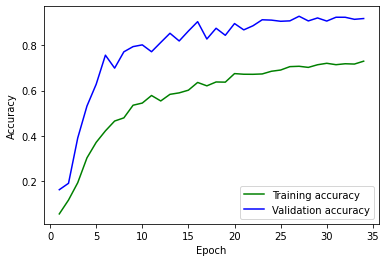

In [ ]:
plot_metric(history, 'accuracy')


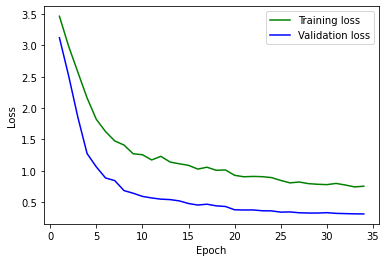

In [ ]:
plot_metric(history, 'loss')

# Part 4: Test Model

In testing the model, I will be using the ```model.evaluate``` function to see how well the model I had built performs with the test dataset.

# 4.1. Pre-processing Test Set

Similar to the train set, I pre-processed the test set using ```ImageDataGenerator```.

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_directory(
    directory=test_path,                          # Training directory
    target_size=(image_x, image_y),                  # Resize to (224, 224) for vgg16 model
    seed=42,
    class_mode='categorical',                        # 26 categories: A-Z
    color_mode='rgb',                                # Convert back from grayscale to RGB
    shuffle=True)


Found 10400 images belonging to 26 classes.


## 4.1. Evaluate Models

Evaluating the models using the ```model.evaluate``` function gives us these results.

In [ ]:
model_vgg = load_model('/content/drive/MyDrive/Colab/ASL/models/vgg16.h5')
loss_vgg, acc_vgg = model_vgg.evaluate(test_gen, verbose=1)

325/325 [==============================] - 28s 86ms/step - loss: 0.0343 - accuracy: 0.9881


In [ ]:
model_resnet = load_model('/content/drive/MyDrive/Colab/ASL/models/resnet50.h5')
loss_resnet, acc_resnet = model_resnet.evaluate(test_gen, verbose=1)

325/325 [==============================] - 30s 88ms/step - loss: 0.3324 - acc: 0.9322


Comparing the optimized models, it seems that the VGG model is better than the ResNet model, even though the ResNet model uses more layers than the vgg model.


However, the bigger issue is that the results from evaluating using ```model.evaluate``` seemed too good to be true. It seemed nigh impossible for the model to have been trained to near-perfection and the ```model.evaluate``` function seemed off. To confirm my suspicion, I created a function to create a dataframe to compare the actual vs predicted gesture.

## 4.2. DataFrame of Results



### 4.2.1. Dictionary for Index Interpretations

I created two dictionaries to identify the gestures in the actual vs predicted separately.

This is because there is a difference between reading the 'actual' gesture from the file and its corresponding index processed using ```ImageDataGenerator```. To put it more simply, my files were not read in ascending order (1, 2, 3 ... 24, 25, 26), but read in the order of the first number (1, 10, 11 ... 18, 19, 2, 20, 21).

In table format, this is how I set my folders:

|Alphabet|Folder Number|
|-------------|--------|
|A|1|
|B|2|
|C|3|
|...|...|
|X|24|
|Y|25|
|Z|26|

```ImageDataGenerator``` indexed the results as such:

| Index No + 1 |Folder Number|Alphabet|
|------------------|--------|-|
|1|1|A|
|2|10|J|
|3|11|K|
|...|...|...|
|11|19|S|
|12|2|B|
|13|20|T|
|14|21|U|
|...|...|...|
|19|26|Z|
|20|3|C|
|21|4|D|

In [42]:
# Reading test folder based on how I made it
number_to_alphabet = {
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 
    7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 
    13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 
    18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 
    23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

# Reading model indexes made by ImageDataGenerator
number_to_alphabet_2 = {
    1: 'A', 2: 'J', 3: 'K', 4: 'L', 5: 'M', 6: 'N', 7: 'O',
    8: 'P', 9: 'Q', 10: 'R', 11: 'S', 12: 'B', 13: 'T', 14: 'U',
    15: 'V', 16: 'W', 17: 'X',  18: 'Y', 19: 'Z', 20: 'C',
    21: 'D', 22: 'E', 23: 'F', 24: 'G', 25: 'H', 26: 'I',
}

### 4.2.2. Function for Model Prediction

In [43]:
def predict_alphabet(select_model, path):

    model = select_model
    # Read and reshape image to be predicted
    read_image = cv2.imread(path, 1)
    reshaped_image = read_image.reshape(1, 224, 224, 3)

    # Predict alphabet based on model
    alphabet_number = np.argmax(model.predict(reshaped_image)[0], axis=0) + 1
    predicted_alphabet = number_to_alphabet_2[alphabet_number]

    # Prediction probability
    predicted_probability = max(model.predict(reshaped_image)[0])

    return predicted_alphabet, predicted_probability

### 4.2.3. Create Actual vs Predicted DataFrame

In [44]:
def predict_dataframe(select_model):
    model = select_model
    general_path = '/content/drive/MyDrive/Colab/ASL/gestures/test/'
    column_names = ['actual', 'predicted', 'predict_proba']
    result = pd.DataFrame(columns=column_names)
    for directory, subdirectories, files in os.walk(general_path):
        for subdirectory in subdirectories:
            for jpg_number in jpg_list:
                image_path = general_path + str(subdirectory) + '/' + str(jpg_number) + '.jpg'
                # Predict alphabet from model
                predicted_alphabet, predict_proba = predict_alphabet(model, image_path)

                # Actual alphabet obtained from file name
                actual_alphabet = number_to_alphabet[int(re.findall('/(\d*)/', image_path)[0])]

                to_add = pd.DataFrame(
                    [actual_alphabet, predicted_alphabet, predict_proba],
                    index=column_names).T

                result = pd.concat(objs=(result, to_add), axis=0)
    return result


## 4.3. Re-evaluate Models

The results obtained from using the function from this section is different from the results evaluated from 4.1. However, it seems like the results obtained from 4.2. is more realistic than the nigh-perfect results from using ```model.evaluate```. Below, we conduct some analysis based on the things we get correctly and incorrectly.

### 4.3.1. VGG16 Model

Here, we compare the results between the model accuracy obtained from 4.1. and 4.2.

In [ ]:
result_vgg = predict_dataframe(model_vgg)
result_vgg.to_csv('/content/drive/MyDrive/Colab/ASL/results/vgg.csv', index=False)

Recalling our accuracy rate from 4.1., accuracy is at 98.8%.

In [ ]:
acc_vgg_percent = round(acc_vgg * 100, 1)
acc_vgg_percent

98.8

Now, we predict the results based on 4.2.

In [ ]:
accurate_preds_vgg = result_vgg.loc[result_vgg['actual'] == result_vgg['predicted']]['actual'].count()
accuracy_rate_vgg = round(accurate_preds/result_vgg.shape[0]*100, 1)
accurate_proba_vgg = round(result_vgg.loc[result['actual'] == result_vgg['predicted']]['predict_proba'].mean()*100, 2)

print(f'Accurate Predictions: {accurate_preds_vgg}')
print(f'Accuracy Rate: {accuracy_rate_vgg}%')
print(f'Mean Probability for Accurate Results: {accurate_proba}%')

Accurate Predictions: 8215
Accuracy Rate: 79.0%
Average Prediction Probability for Accurate Results: 99.9%


Using the functions in 4.2., I find that there were 8,215 images that were correctly classified. This translates to an accuracy rate of 79%. This seems more correct than the 98.8% accuracy rate from 4.1.

For the images where the model obtained the correct predictions, there was a very high prediction probability at 99.9%

In [ ]:
inaccurate_proba_vgg = round(result_vgg.loc[result_vgg['actual'] != result_vgg['predicted']]['predict_proba'].mean()*100, 2)

print(f'Mean Probability for Inaccurate Results: {inaccurate_proba_vgg}%')

Mean Probability for Inaccurate Results: 99.25%


On the other hand, where the predictions were inaccurate, there was a lower prediction probability. However, the prediction probability was still very high, which is very concerning. From this, I believe that the model will require even more training, perhaps with more dataset and added layers. But for this project, I am satisfied with the outcome (due to the lack of time and computing power).

### 4.3.2. ResNet Model

Here, we compare the results between the model accuracy obtained from 4.1. and 4.2.

In [45]:
model_resnet = load_model('/content/drive/MyDrive/Colab/ASL/models/resnet50.h5')

In [49]:
result_resnet = predict_dataframe(model_resnet)
result_resnet.to_csv('/content/drive/MyDrive/Colab/ASL/results/resnet.csv', index=False)

Recalling our accuracy rate from 4.1., accuracy is at 93.2%.

In [50]:
result_resnet

,actual,predicted,predict_proba
0,A,S,0.876713
0,A,S,0.659585
0,A,S,0.943189
0,A,S,0.938809
0,A,S,0.851843
...,...,...,...
0,Z,S,0.588154
0,Z,A,0.622494
0,Z,S,0.312844
0,Z,S,0.782017


In [ ]:
acc_resnet_percent = round(acc_resnet * 100, 1)
acc_resnet_percent

93.2

Now, we predict the results based on 4.2.

In [53]:
accurate_preds_resnet = result_resnet.loc[result_resnet['actual'] == result_resnet['predicted']]['actual'].count()
accuracy_rate_resnet = round(accurate_preds_resnet/result_resnet.shape[0]*100, 1)
accurate_proba_resnet = round(result_resnet.loc[result_resnet['actual'] == result_resnet['predicted']]['predict_proba'].mean()*100, 2)

print(f'Accurate Predictions: {accurate_preds_resnet}')
print(f'Accuracy Rate: {accuracy_rate_resnet}%')
print(f'Mean Probability for Accurate Results: {accurate_proba_resnet}%')

Accurate Predictions: 738
Accuracy Rate: 7.1%
Mean Probability for Accurate Results: 86.72%


Using the functions in 4.2., I find that there were 738 images that were correctly classified. This translates to an accuracy rate of 7.1%. This seems more correct than the 93.2% accuracy rate from 4.1. However, the low accuracy suggests that this model should not be used.

In [54]:
inaccurate_proba_resnet = round(result_resnet.loc[result_resnet['actual'] != result_resnet['predicted']]['predict_proba'].mean()*100, 2)

print(f'Mean Probability for Inaccurate Results: {inaccurate_proba_resnet}%')

Mean Probability for Inaccurate Results: 75.07%


However, what's interesting here is, the mean probability of the incorrect predictions were much lower. A lower probability in incorrect classification suggests that the model was trained properly.

But overall, running and optimizing this model proved futile. If anything, it simply showed that this model, with it's full 50 layers and then some, is horrifyingly terrible at predicting this type of data.

## 4.4. Misclassification Analysis

In this section, I use the optimized VGG16 model above to conduct some misclassification analysis.

Looking at the top 5 misclassified letters, we get the following results:


In [ ]:
result_vgg.loc[result_vgg['actual'] != result_vgg['predicted']].groupby(
    ['actual']).count().sort_values(by=['predicted'], ascending=False).head()

,predicted,predict_proba
actual,,
J,266,266
U,227,227
F,193,193
B,188,188
C,124,124


Next, I identify one of the most commonly misclassified letters and view the classes where it is misclassified onto. The 'actual' alphabet selected is 'C'.

In [ ]:
result_vgg.loc[(result_vgg['actual'] != result_vgg['predicted']) &
               (result_vgg['actual'] == 'C')].groupby(
               ['actual', 'predicted']).count()

predict_proba
actual predicted               
C      E                     84
       M                      3
       N                     30
       O                      2
       Q                      1
       S                      4

Most of the incorrectly classified 'C's were misclassified as 'E'. Below, we show the gestures C and E.

In [ ]:
def show_image(alphabet_number, image_number):
    jpg_number = jpg_list[image_number - 1]
    image_path = f'/content/drive/MyDrive/Colab/ASL/gestures/test/{alphabet_number}/{jpg_number}.jpg'
    read_image = cv2.imread(image_path, 1)
    resize_image = cv2.resize(read_image, (image_x, image_y))
    cv2_imshow(resize_image)
    return print(f'Alphabet: {number_to_alphabet[alphabet_number]}')


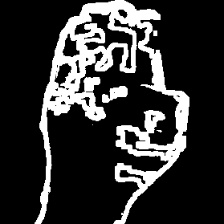

Alphabet: C


In [ ]:
show_image(3, 1)

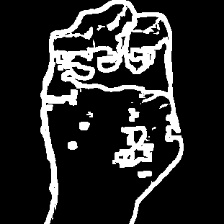

Alphabet: E


In [ ]:
show_image(5, 1)

As shown above, the gestures for 'C' and 'E' were very similar. Therefore, misclassifcation occurs.

Meanwhile, gestures that were unique has better accuracy. Below is a table of the top 5 most accurate gestures.

In [ ]:
result_vgg.loc[result_vgg['actual'] == result_vgg['predicted']].groupby(
    ['actual']).count().sort_values(by=['predicted'], ascending=False).head()

,predicted,predict_proba
actual,,
R,395,395
Q,394,394
O,391,391
N,384,384
E,378,378


The images which are most accurate had gestures that are more different than others. I show some of these gestures below:

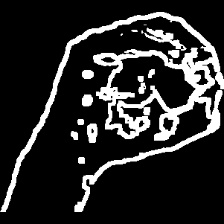

Alphabet: O


In [ ]:
show_image(15, 1)

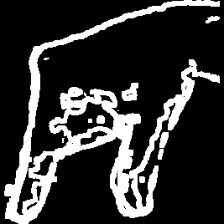

Alphabet: Q


In [ ]:
show_image(17, 1)

In general, misclassification occurs when the gestures are too similar. As such, gestures that are less similar to another gestures in the corpus are better predicted. 

## 4.5. (Extra) Predicting Single Images

Here, I made a function to predict single images. This is used just to fool around in predicting single images based on the file location.

In [ ]:
def predict_one(model_path, alphabet_number, image_number):
    '''
    Comparison of actual alphabet vs model prediction. Also shows image.

    model_selected (str): Model used to predict
    alphabet_number (int): Numericized alphabet based on number_to_alphabet (1-26)
    image_number(int): Index number of selected image number (1-400)
    '''

    # Setting image size
    image_x, image_y = 224, 224

    model = load_model(model_path)
    
    # Column names for aggregation to dataframe
    column_names = ['actual', 'predicted', 'predict_proba']

    jpg_number = jpg_list[image_number - 1]

    image_path = f'/content/drive/MyDrive/Colab/ASL/gestures/test/{alphabet_number}/{jpg_number}.jpg'

    # read image
    read_image = cv2.imread(image_path, 1)
    resize_image = cv2.resize(read_image, (image_x, image_y))
    cv2_imshow(resize_image)

    # ACTUAL alphabet based on folder
    actual_alphabet = number_to_alphabet[alphabet_number]
    
    # PREDICTED alphabet based on model
    reshaped_image = read_image.reshape(1, 224, 224, 3)
    predicted_index = np.argmax(model.predict(reshaped_image)[0], axis=0)
    predicted_alphabet = number_to_alphabet_2[predicted_index + 1]

    # PREDICTION probability based on model
    predicted_probability = max(model.predict(reshaped_image)[0])

    # Placing into dataframe for easier viewing
    single_prediction = pd.DataFrame(
        [actual_alphabet, predicted_alphabet, predicted_probability],
        index=column_names).T

    return single_prediction

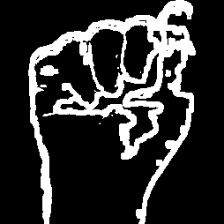

,actual,predicted,predict_proba
0,A,A,1


In [ ]:
model_vgg_path = '/content/drive/MyDrive/Colab/ASL/models/vgg16.h5'
predict_one(
    model_path=model_vgg_path,
    alphabet_number=1,
    image_number=1
)

The function works as such: By inputting the alphabet number (1 = A, 2 = B, etc) and selecting the image_number (1 to 400), I can see whether the model was predicting the gesture correctly. Doing this helps visually identify some of the common characteristics of misclassified images from each gesture.

# Part 5: Conclusion and Recommendations

## Conclusions

Some conclusions from the models.

Epoch size should be adjusted to the number of classes available in the dataset. As mentioned before, when I had set epoch size to 32, there was an average of 1 gesture included per batch, which caused the model to be unable to predict anything substantial. Therefore, I had increased the batch size to 256, which means that on average, there will be about 10 gestures per batch. This provided the model with greater predictive power.

On the number of layers, I found that it was generally unnecessary to train the pre-trained models. As such, I had frozen the pre-trained models. Excluding the top, while including a few added layers of my own, had provided the model with greater predictive power. However, with the added layers, there was a need to adjust dropout size accordingly. A dropout too low or too high would cause the model to overfit or underfit respectively.

On the model results, I found that in general, gestures that were different from others was predicted better. In creating my dataset, I had minded to prevent overfitting to the same gesture, and as such, I had rotated and shifted my hand around to provide it with some noise. As a result, somes gestures looked more similar to other gestures beyond it's original shape. However, this was a necessary trade-off because choosing not to provide some noise into the dataset would cause the models to be too strict in predicting the gestures, and thus, minute differences in gestures would result in a worse accuracy rate.

Overall, this project was pretty fun for me as I explored new libraries (OpenCV, etc), which allowed me to expand my personal toolkit.

## Recommendations

In improving this model, there are a few things that I have in mind:      

1. Increase the dataset size.
2. Increase layers and optimize the models accordingly.
3. Implement a live-test whereby a camera can be used to test the model in real time.